Worth exploring
* Is SVM using OVR?

# Definition

## Project Overview

* Project Origin: [Kaggle - Facebook V: Predicting Check Ins](https://www.kaggle.com/c/facebook-v-predicting-check-ins)
* Description: Facebook and Kaggle launched a machine learning engineering competition of identifying the correct place for check ins. For giving a flavor of what it takes to work with real data, Facebook created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square and data was fabricated to resemble location signals coming from mobile devices.
* Data sets:
    * train.csv, test.csv
        * row_id: id of the check-in event
        * x y: coordinates
        * accuracy: location accuracy 
        * time: timestamp
        * place_id: id of the business (this is the target I'm  predicting)

## Problem Statement

* Goal: The goal is to predict a ranked list of place a person would like to check in to.
* Proposed Solution:
    * TBD

## Metrics

* Prediction is evaluated according to the [Mean Average Precision @3](https://www.kaggle.com/wiki/MeanAveragePrecision)  (MAP@3)
\begin{equation*}
    MAP@3 = \frac{1}{|U|} \sum_{u=1}^{|U|} \sum_{k=1}^{min(3,n)} P(k)
\end{equation*}
where |U| is the number of check in events, P(k) is the precision at cutoff k, n is the number of predicted businesses.
* MAP is chosen because the prediction would be a list of ranked place and the order of place matters.

# Analysis

## Data Exploration

In [60]:
import math
import pandas as pd
import numpy as np
# For plotting
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
print 'Size of training data: {}'.format(df_train.shape)
print 'Size of testing data: {}'.format(df_test.shape)
print 'Columns of data: {}'.format(df_train.columns.values)
print "Description of training data: \n"
print df_train.describe()

Size of training data: (29118021, 6)
Size of testing data: (8607230, 5)
Columns of data: ['row_id' 'x' 'y' 'accuracy' 'time' 'place_id']
Description of training data: 

                row_id                x                y         accuracy  \
count  29118021.000000  29118021.000000  29118021.000000  29118021.000000   
mean   14559010.000000         4.999770         5.001814        82.849125   
std     8405648.775656         2.857601         2.887505       114.751772   
min           0.000000         0.000000         0.000000         1.000000   
25%     7279505.000000         2.534700         2.496700        27.000000   
50%    14559010.000000         5.009100         4.988300        62.000000   
75%    21838515.000000         7.461400         7.510300        75.000000   
max    29118020.000000        10.000000        10.000000      1033.000000   

                  time      place_id  
count  29118021.000000  2.911802e+07  
mean     417010.364723  5.493787e+09  
std      231176.1464

### Coordinate
* We can see that the check ins are roughly uniformly distributed on the map.
* Because the number of data is huge, only taking 1% of random sample to investigate the distribution of x and y. 

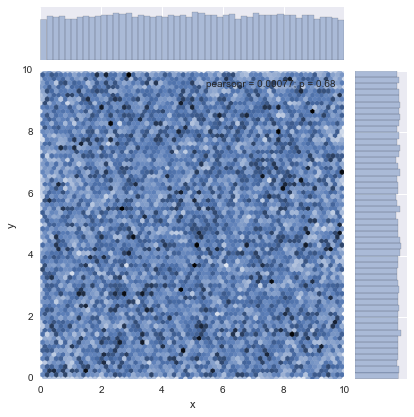

In [22]:
sns.jointplot(data=df_train.sample(frac=0.01), x='x',y='y',kind='hex')

### Accuracy
* From the histogram of accuracy, we could know that majority of value is **under 200**.
* The meaning of accuracy is still vague.

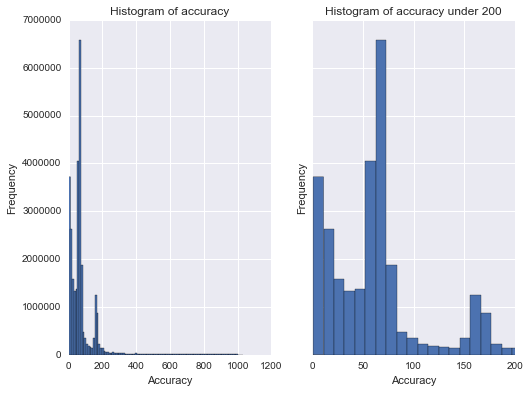

In [34]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title('Histogram of accuracy')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Frequency')
df_train['accuracy'].hist(bins=100,ax=ax1)
ax2.set_title('Histogram of accuracy under 200')
ax2.set_xlim((0,200))
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Frequency')
df_train['accuracy'].hist(bins=100,ax=ax2)

### Place Ids
* From this section, we can know that there are a huge number of place ids and they are not uniformly distributed. This means that any algorithm which trains using a one vs all approach would not be the best choice on this dataset.
* What is "one vs all approach"?
    * This approach is training a single classifier per class for solving multiclass problems of n classes with the samples of that class as positive samples and all other samples as negatives. [( Reference-Wiki )](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)

In [68]:
print "Number of unique place id: {}, roughly {:.3f} % of traing data.".format(len(df_train['place_id'].unique()), 
                                                                               len(df_train['place_id'].unique()) * 100.0 / df_train.shape[0])

Number of unique place id: 108390, roughly 0.372 % of traing data.


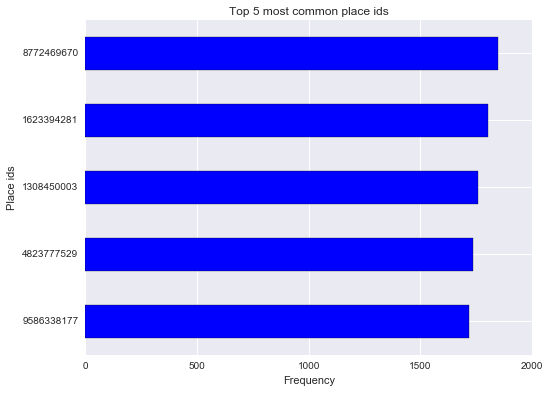

In [3]:
plt.xlabel('Frequency')
plt.ylabel('Place ids')
df_train['place_id'].value_counts().head(5).plot.barh(title='Top 5 most common place ids', xlim=(0,2000)).invert_yaxis()

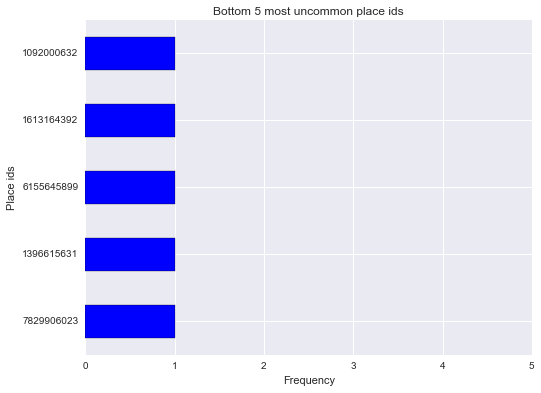

In [4]:
plt.xlabel('Frequency')
plt.ylabel('Place ids')
df_train['place_id'].value_counts().tail(5).plot.barh(title='Bottom 5 most uncommon place ids', xlim=(0,5))

## Exploratory Visualization

### Explore Time

* Because the column of time is intentionally left vague without defining the unit of time, this section provides two methods to conclude the unit of time would be minute.
* Method 1: Converted the time to week at the top 3 place in order to find in order to visualize the weekly cycles. [(Reference)](https://www.kaggle.com/jsab16/facebook-v-predicting-check-ins/on-time/comments)

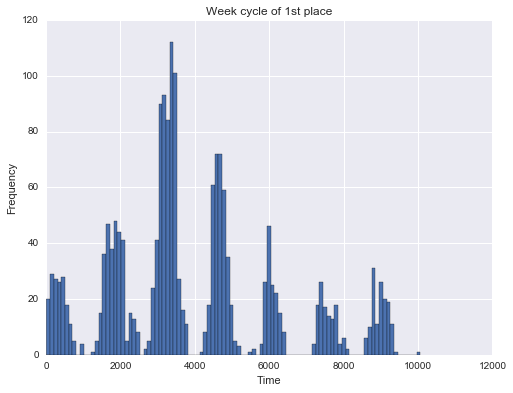

In [21]:
# Top 1 place : 8772469670
time = df_train[df_train['place_id']==8772469670]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 1st place')
time.hist(bins=100)

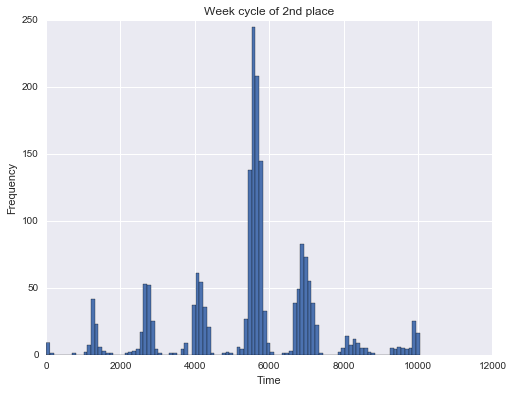

In [22]:
# Top 2 place : 1623394281
time = df_train[df_train['place_id']==1623394281]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 2nd place')
time.hist(bins=100)

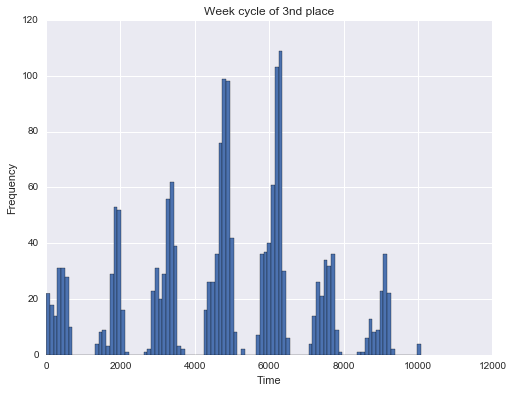

In [24]:
# Top 3 place : 1308450003
time = df_train[df_train['place_id']==1308450003]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 3nd place')
time.hist(bins=100)

* Method 2: Used Fourier transform to extract the dominant frequency in order to find the period at the top 3 place. [(Reference)](https://www.kaggle.com/leonlu/facebook-v-predicting-check-ins/another-way-to-know-the-time-definition/comments)

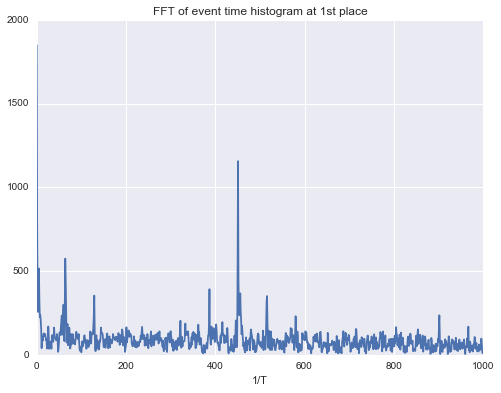

1st period: 10151.96875, close to 10080 minutes a week.
2nd period: 1440.63414634, close to 1440 minutes a day.


In [64]:
# Top 1 place : 8772469670
time = df_train[df_train['place_id']==8772469670]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

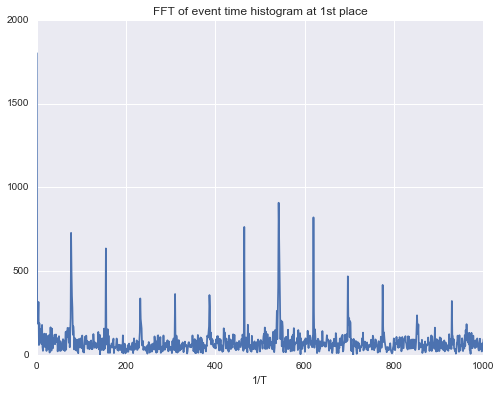

1st period: 10200.4155844, close to 10080 minutes a week.
2nd period: 1449.13653137, close to 1440 minutes a day.


In [63]:
# Top 2 place : 1623394281
time = df_train[df_train['place_id']==1623394281]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

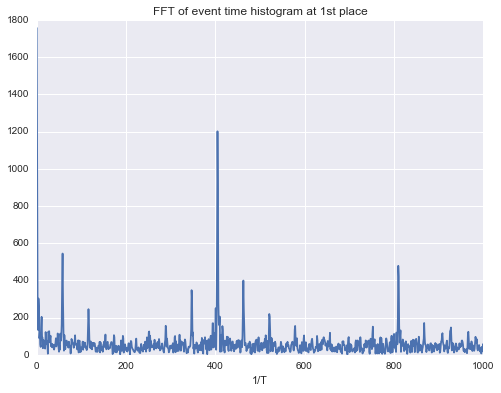

1st period: 10138.9482759, close to 10080 minutes a week.
2nd period: 1451.99753086, close to 1440 minutes a day.


In [60]:
# Top 3 place : 1308450003
time = df_train[df_train['place_id']==1308450003]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[300:500].argmax()+300.0))

Since we found that the unit of time is minute, we could add more fields based on time, **hours, weekday, month, year**.

In [ ]:
df_train['hours'] = ((df_train['time']/60)%24).astype(int)
df_train['weekday'] = ((df_train['time']/(60*24))%7).astype(int)
df_train['month'] = ((df_train['time']/(60*24*30))%12).astype(int)
df_train['year'] = ((df_train['time']/(60*24*365))).astype(int)

### Explore small grid

In [55]:
small_grid = df_train[(df_train['x']<0.1)&(df_train['y']<0.1)]

In [71]:
color = dict(zip(small_grid['place_id'].unique(), np.linspace(0,1,small_grid['place_id'].unique().shape[0])))

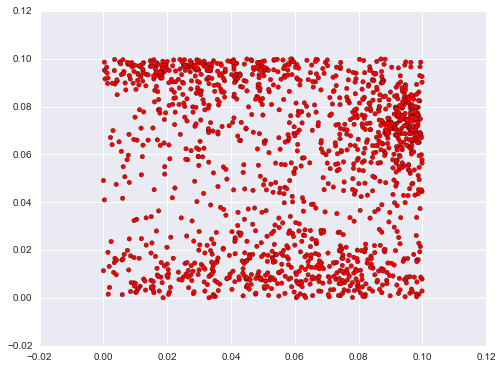

In [62]:
plt.scatter(small_grid['x'],small_grid['y'],c=cm.rainbow())

### Explore Accuracy

In [3]:
place1 = 8772469670
place2 = 1623394281
place3 = 1308450003

In [154]:
data = df_train.groupby(['place_id',pd.cut(df_train['accuracy'],np.arange(0,900,100))])

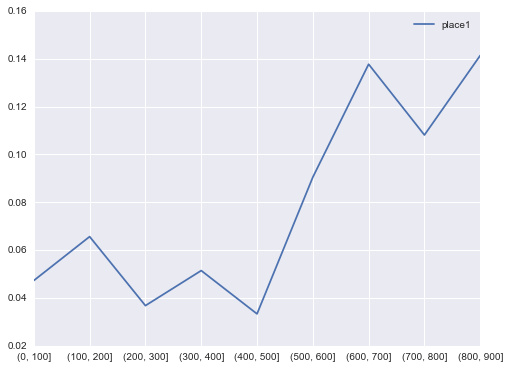

In [155]:
sections = []
values = []
median = data_by_place.loc[place1]['x'].median()
for i in range(10):
    section = '({}, {}]'.format(i*100,(i+1)*100)
    try:
        value = np.abs((data.get_group((place1,section))['x'] - median)).median()
    except KeyError:
        value = float('nan')
    finally:
        if not math.isnan(value):
            sections.append(section)
            values.append(value)
pd.DataFrame({'place1': values},index=sections).plot()

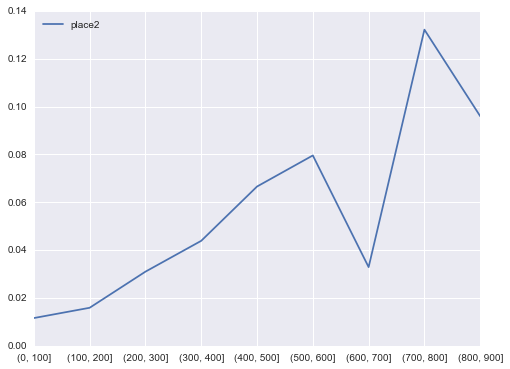

In [156]:
sections = []
values = []
median = data_by_place.loc[place2]['x'].median()
for i in range(10):
    section = '({}, {}]'.format(i*100,(i+1)*100)
    try:
        value = np.abs(data.get_group((place2,section))['x'] - median).median()
    except KeyError:
        value = float('nan')
    finally:
        if not math.isnan(value):
            sections.append(section)
            values.append(value)
pd.DataFrame({'place2': values},index=sections).plot()

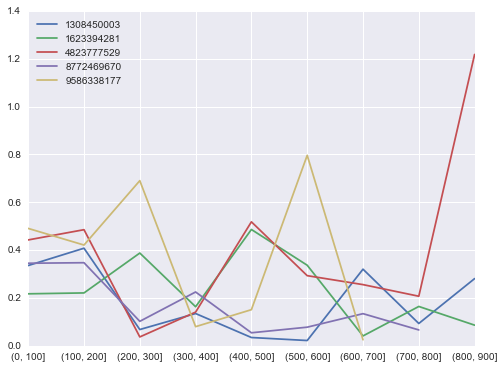

In [163]:
result = {}
sections = []
for i in range(9):
    section = '({}, {}]'.format(i*100,(i+1)*100)
    sections.append(section)
for place in df_train['place_id'].value_counts().head(5).index.values:
    values = []
    median = data_by_place.loc[place]['x'].median()
    for section in sections:
        value = np.abs(data.get_group((place,section))['x'] - median).std()
        values.append(value)
    result[place] = values
pd.DataFrame(result,index=sections).plot()

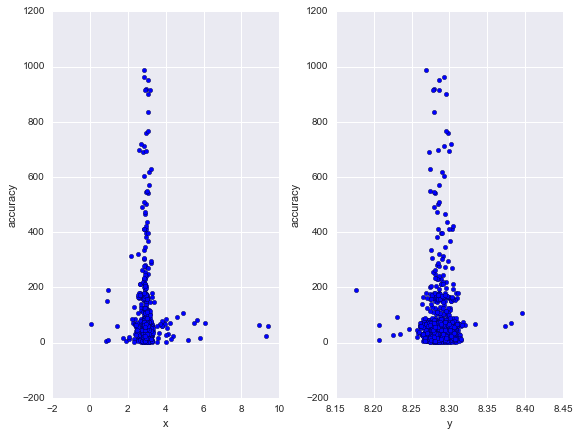

In [171]:
plt.subplot(1,2,1)
plt.scatter(data_by_place.loc[8772469670]['x'], data_by_place.loc[8772469670]['accuracy'])
plt.xlabel('x')
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.scatter(data_by_place.loc[8772469670]['y'], data_by_place.loc[8772469670]['accuracy'])
plt.xlabel('y')
plt.ylabel('accuracy')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

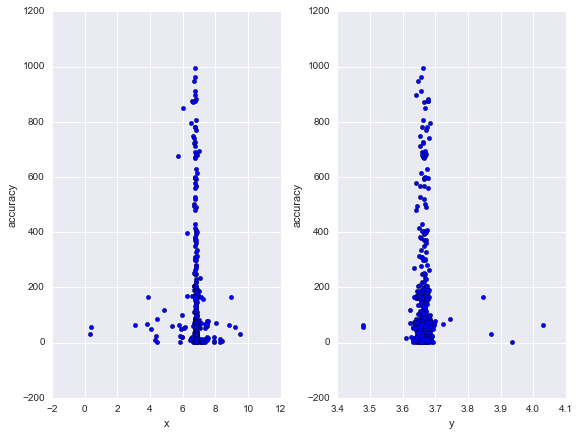

In [170]:
plt.subplot(1,2,1)
plt.scatter(data_by_place.loc[1308450003]['x'], data_by_place.loc[1308450003]['accuracy'])
plt.xlabel('x')
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.scatter(data_by_place.loc[1308450003]['y'], data_by_place.loc[1308450003]['accuracy'])
plt.xlabel('y')
plt.ylabel('accuracy')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

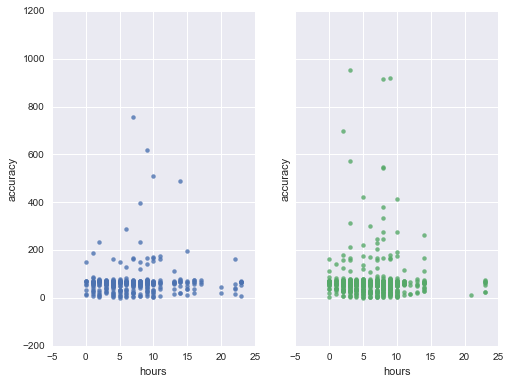

In [189]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x='hours',y='accuracy',data=data_by_place[data_by_place['day']==1].loc[place1],fit_reg=False,ax=ax1)
sns.regplot(x='hours',y='accuracy',data=data_by_place[data_by_place['day']==2].loc[place1],fit_reg=False,ax=ax2)

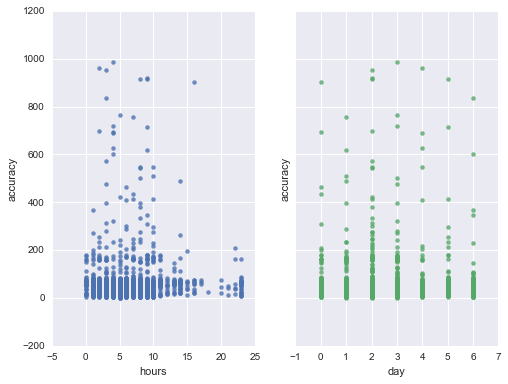

In [182]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x='hours',y='accuracy',data=data_by_place.loc[place1],fit_reg=False,ax=ax1)
sns.regplot(x='day',y='accuracy',data=data_by_place.loc[place1],fit_reg=False,ax=ax2)

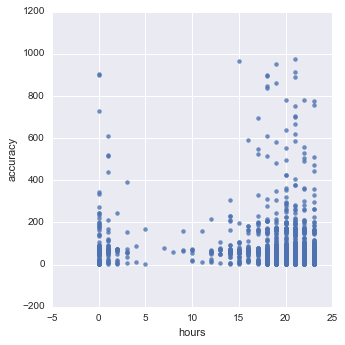

In [176]:
sns.lmplot(x='hours',y='accuracy',data=data_by_place.loc[place2],fit_reg=False)

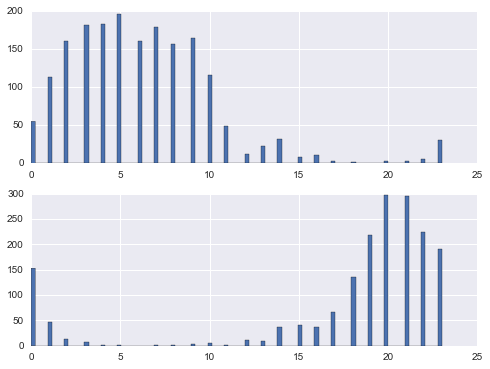

In [14]:
plt.subplot(211)
df_train[df_train['place_id']==place1]['hours'].hist(bins=100)
plt.subplot(212)
df_train[df_train['place_id']==place2]['hours'].hist(bins=100)

In [35]:
import plotly

ImportError: No module named plotly